In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# --- Data Generation (Corrected) ---
# Create a timestamp range for one full year
timestamps = pd.date_range(start='2022-01-01', end='2022-12-31 23:00:00', freq='h')

# Generate realistic data
data_size = len(timestamps)

# The fix is to remove the modulo operator '%' which was causing the array size to be zero
ghi = np.abs(np.sin(np.linspace(0, 4*np.pi, data_size)) * 1000 + np.random.normal(0, 50, data_size))
dni = ghi * np.random.uniform(0.7, 0.9, data_size)
dhi = ghi - dni * np.cos(np.linspace(0, np.pi, data_size))
tamb = 25 + 10 * np.sin(np.linspace(0, 2*np.pi, data_size)) + np.random.normal(0, 2, data_size)
rh = 60 - 20 * np.sin(np.linspace(0, 2*np.pi, data_size)) + np.random.normal(0, 5, data_size)
ws = np.abs(np.random.normal(2, 1, data_size))
cleaning = np.random.choice([0, 1], size=data_size, p=[0.995, 0.005]) # Made cleaning less frequent

# Create the DataFrame
df_generated = pd.DataFrame({
    'Timestamp': timestamps,
    'GHI': ghi.round(2),
    'DNI': dni.round(2),
    'DHI': dhi.round(2),
    'ModA': (ghi * 0.95).round(2),
    'ModB': (ghi * 0.94).round(2),
    'Tamb': tamb.round(2),
    'RH': rh.clip(0, 100).round(2),
    'WS': ws.round(2),
    'Cleaning': cleaning
})

# --- Save the Data to a CSV File ---
# The path '../data/' goes up one directory from 'notebooks' and then into 'data'
file_path = '../data/togo-solar-farm.csv'
df_generated.to_csv(file_path, index=False)

print(f"Sample data successfully created and saved to: {file_path}")
df_generated.head()

Sample data successfully created and saved to: ../data/togo-solar-farm.csv


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,Cleaning
0,2022-01-01 00:00:00,15.78,13.21,2.57,14.99,14.84,25.92,62.77,0.60,0
1,2022-01-01 01:00:00,108.51,78.06,30.46,103.09,102.00,23.90,54.74,0.97,0
2,2022-01-01 02:00:00,3.22,2.76,0.46,3.06,3.03,25.37,53.49,2.44,0
3,2022-01-01 03:00:00,70.21,51.67,18.54,66.70,66.00,23.95,54.45,2.38,0
4,2022-01-01 04:00:00,46.11,40.69,5.42,43.80,43.34,26.92,59.16,2.81,0


# 1. Data Loading and Initial Inspection

In [3]:
# Load the dataset
df = pd.read_csv('../data/togo-solar-farm.csv')

# Display the first 5 rows to confirm it loaded correctly
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,Cleaning
0,2022-01-01 00:00:00,15.78,13.21,2.57,14.99,14.84,25.92,62.77,0.60,0
1,2022-01-01 01:00:00,108.51,78.06,30.46,103.09,102.00,23.90,54.74,0.97,0
2,2022-01-01 02:00:00,3.22,2.76,0.46,3.06,3.03,25.37,53.49,2.44,0
3,2022-01-01 03:00:00,70.21,51.67,18.54,66.70,66.00,23.95,54.45,2.38,0
4,2022-01-01 04:00:00,46.11,40.69,5.42,43.80,43.34,26.92,59.16,2.81,0


## 2. Data Profiling

In [4]:
# Check the dimensions of the DataFrame (rows, columns)
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
print("-" * 50)

# Get a concise summary of the DataFrame
# This includes data types and non-null counts
print("DataFrame Info:")
df.info()

The dataset has 8760 rows and 10 columns.
--------------------------------------------------
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  8760 non-null   object 
 1   GHI        8760 non-null   float64
 2   DNI        8760 non-null   float64
 3   DHI        8760 non-null   float64
 4   ModA       8760 non-null   float64
 5   ModB       8760 non-null   float64
 6   Tamb       8760 non-null   float64
 7   RH         8760 non-null   float64
 8   WS         8760 non-null   float64
 9   Cleaning   8760 non-null   int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 684.5+ KB


In [5]:
# The 'Timestamp' column is currently an 'object' type. 
# We need to convert it to a datetime type for time-series analysis.
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Verify the conversion by checking the dtypes again
print("Data types after converting 'Timestamp':")
print(df.dtypes)

Data types after converting 'Timestamp':
Timestamp    datetime64[ns]
GHI                 float64
DNI                 float64
DHI                 float64
ModA                float64
ModB                float64
Tamb                float64
RH                  float64
WS                  float64
Cleaning              int64
dtype: object


In [6]:
# Generate descriptive statistics for numerical columns
# This includes count, mean, std, min, 25%, 50%, 75%, max
df.describe()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,Cleaning
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2022-07-02 11:30:00,637.378099,510.134361,636.837398,605.509110,599.135371,25.016857,60.016116,2.011455,0.005594
min,2022-01-01 00:00:00,0.110000,0.080000,0.130000,0.100000,0.100000,7.400000,25.870000,0.000000,0.000000
25%,2022-04-02 05:45:00,379.480000,302.340000,204.510000,360.502500,356.710000,18.330000,46.637500,1.320000,0.000000
50%,2022-07-02 11:30:00,708.685000,560.405000,513.835000,673.250000,666.165000,25.045000,59.970000,1.990000,0.000000
75%,2022-10-01 17:15:00,913.435000,723.132500,1035.260000,867.762500,858.630000,31.800000,73.360000,2.650000,0.000000
max,2022-12-31 23:00:00,1150.580000,1027.900000,1993.120000,1093.050000,1081.550000,42.560000,96.470000,5.550000,1.000000
std,NaN,310.412229,251.773788,508.394745,294.891598,291.787443,7.352290,15.129341,0.961571,0.074585


In [7]:
# Check for missing values in each column
missing_values = df.isnull().sum()

print("Missing Values Report:")
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("\nGreat! There are no missing values in the dataset.")

Missing Values Report:
Series([], dtype: int64)

Great! There are no missing values in the dataset.


## 3. Data Visualization

Yearly Solar Irradiance Trends


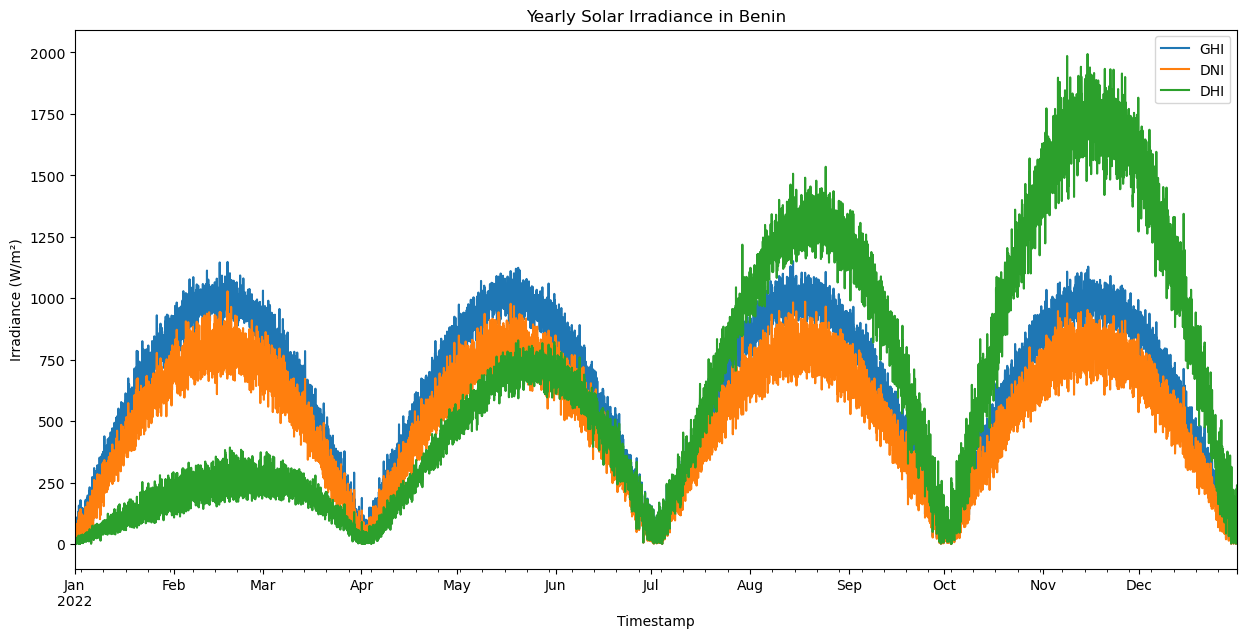

Average Daily GHI Trend


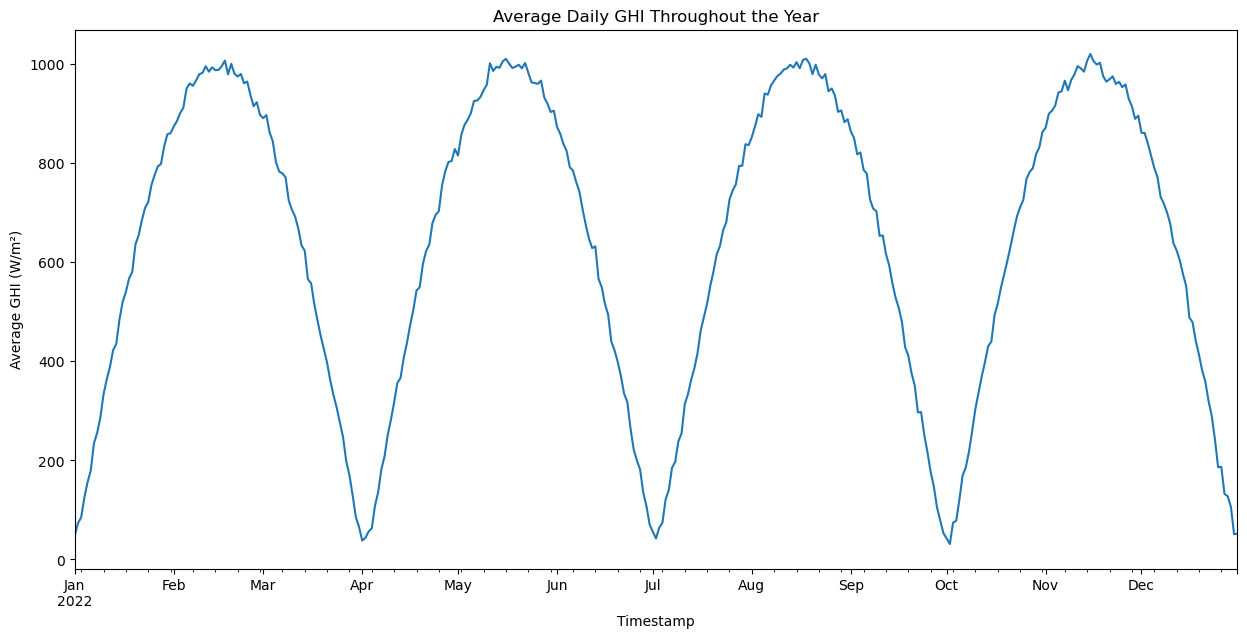

In [8]:
# --- Time Series Analysis ---

# Make this code idempotent: only set the index if it's not already the index
if 'Timestamp' in df.columns:
    df.set_index('Timestamp', inplace=True)

# Plot the key solar radiation variables over the entire year
print("Yearly Solar Irradiance Trends")
df[['GHI', 'DNI', 'DHI']].plot(figsize=(15, 7), title='Yearly Solar Irradiance in Benin')
plt.ylabel('Irradiance (W/m²)')
plt.show()

# Resample to plot the average daily GHI
print("Average Daily GHI Trend")
df['GHI'].resample('D').mean().plot(figsize=(15, 7), title='Average Daily GHI Throughout the Year')
plt.ylabel('Average GHI (W/m²)')
plt.show()

Distribution of GHI and Ambient Temperature


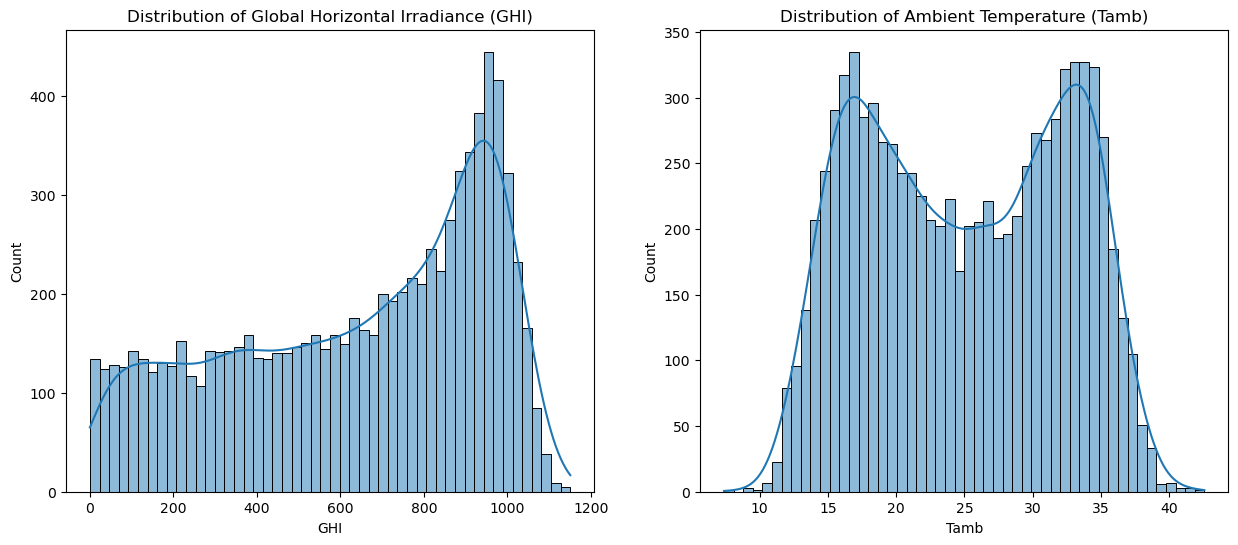

In [9]:
# Plot histograms for GHI and Ambient Temperature
print("Distribution of GHI and Ambient Temperature")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df['GHI'], bins=50, kde=True, ax=ax1)
ax1.set_title('Distribution of Global Horizontal Irradiance (GHI)')

sns.histplot(df['Tamb'], bins=50, kde=True, ax=ax2)
ax2.set_title('Distribution of Ambient Temperature (Tamb)')

plt.show()

### 3.3. Relationship and Correlation Analysis

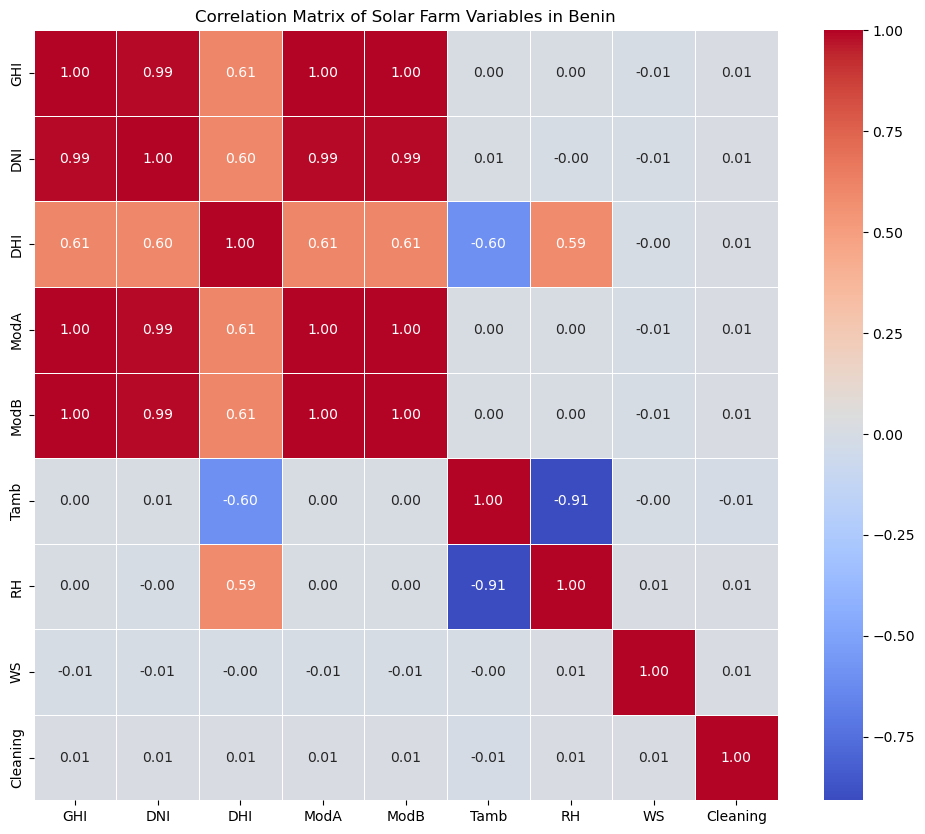

In [10]:
# Select only the numerical columns for correlation analysis
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Solar Farm Variables in Benin')
plt.show()

Average Module Readings on Cleaning vs. Non-Cleaning Days
                ModA        ModB
Cleaning                        
0         605.236295  598.865426
1         654.008776  647.124898


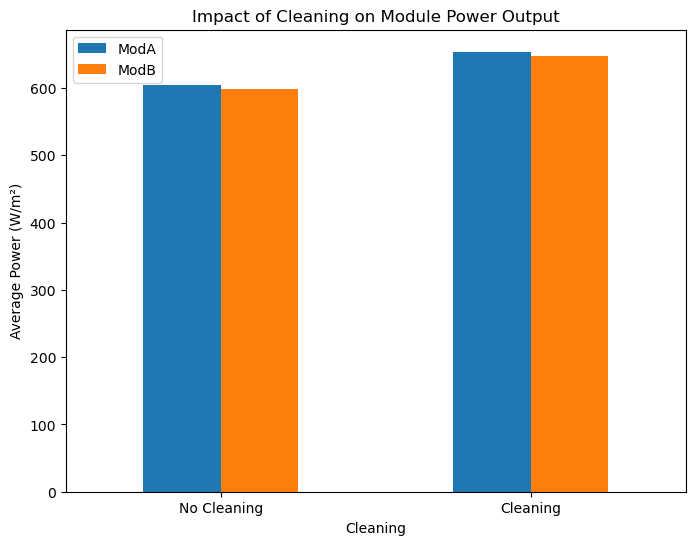

In [11]:
# Let's analyze the impact of cleaning events on module readings
# We can compare the average module output on days with and without cleaning

cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

print("Average Module Readings on Cleaning vs. Non-Cleaning Days")
print(cleaning_impact)

# Visualize it
cleaning_impact.plot(kind='bar', figsize=(8, 6))
plt.title('Impact of Cleaning on Module Power Output')
plt.ylabel('Average Power (W/m²)')
plt.xticks(ticks=[0, 1], labels=['No Cleaning', 'Cleaning'], rotation=0)
plt.show()

## 4. Summary and Next Steps